In [2]:
import pandas as pd
import pickle
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from collections import Counter

import numpy as np
import spacy
from string import punctuation

In [3]:
# df = pd.read_csv('C:/Saravana/Data/Raw/2016.log')
df = pd.read_pickle('C:/Saravana/Data/Raw/export-cleansed-4851f054c66579780503d70880731802.pkl.bz2')
display(df.head())

,IMP_ID,GJ,IMPORT,MUFO_REFERENZ_N,BARCODE_NR,VERANST_SEGMENT,REKLA_JN,VG_DATUM_VON,VG_ORT,VG_RAUM,...,VERANST_ORT,NUTZLIZNEHM_GESCHAEFTSZEICHEN,NUTZLIZNEHM_NAME,NUTZLIZNEHM_VORNAME,NUTZLIZNEHM_STRASSE,NUTZLIZNEHM_PLZ,NUTZLIZNEHM_ORT,LOCATION,BAND,PROMOTER
ID,,,,,,,,,,,,,,,,,,,,,
9938765,24643,2016,ABRE U INKA 2016,NaN,5027961220,4.0,NONRekla,2014-02-09,LISBERG,TURNHALLE SV RW LISBERG,...,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,NaN,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938766,24643,2016,ABRE U INKA 2016,NaN,5027961235,6.0,NONRekla,2014-02-08,LISBERG,TURNHALLE SV RW LISBERG,...,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938851,24643,2016,ABRE U INKA 2016,NaN,5044481411,3.0,NONRekla,2014-03-15,MUENCHEN,WERNER-VON-SIEMENS-SCHULZENTRUM,...,MUENCHEN,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,MUENCHEN WERNER-VON-SIEMENS-SCHULZENTRUM,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938852,24643,2016,ABRE U INKA 2016,NaN,5044481427,2.0,NONRekla,2014-03-14,MUENCHEN,PFARRHEIM UND KIRCHE,...,MUENCHEN,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,MUENCHEN PFARRHEIM UND KIRCHE,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938853,24643,2016,ABRE U INKA 2016,NaN,5044481469,2.0,NONRekla,2014-02-09,GRAFENRHEINFELD,KULTURHALLE GRAFENRHEINFELD,...,WERNECK,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,GRAFENRHEINFELD KULTURHALLE GRAFENRHEINFELD,NaN,MUSIKVEREIN WERNECK E.V 97440


In [18]:
pd.set_option('display.max_columns', None)

In [105]:
pd.set_option('display.max_rows', None)

In [ ]:
df.VERANST_SEGMENT.unique()

In [ ]:
df.VG_RAUM.unique()

In [ ]:
len(df.index)

In [4]:
# Convert all the event segments > 3 to a event segment - 4
df.loc[df['VERANST_SEGMENT'] > 3, 'VERANST_SEGMENT'] = 4

In [5]:
# Filter segment 2(0-50 euros) & segment 3(50-100 euros) & segment 4(>100 euros)
allclaims_df = df.query('VERANST_SEGMENT <= 4')
len(allclaims_df.index)

3296137

In [ ]:
# Filter segment 2(0-50 euros) & segment 3(50-100 euros) 
# lowerclaim_df = df.query('VERANST_SEGMENT <= 3')
# len(lowerclaim_df.index)

In [6]:
# Remove missing values from VG_ORT
allclaims_df = allclaims_df[allclaims_df['VG_ORT'].isnull()==False]
len(allclaims_df.index)

3295915

In [125]:
display(allclaims_df.columns)
# Count NaN values for each column in the dataframe
display(allclaims_df.isna().sum())

Index(['IMP_ID', 'GJ', 'IMPORT', 'MUFO_REFERENZ_N', 'BARCODE_NR',
       'VERANST_SEGMENT', 'REKLA_JN', 'VG_DATUM_VON', 'VG_ORT', 'VG_RAUM',
       'NUTZFALL', 'NUTZFALL_RAUM', 'MUSIKLEITER_NAME', 'KAPELLE_NAME',
       'TARIF_NR', 'TARIF_BEZ', 'NUTZFALL_NR', 'VG_INKASSO', 'INKASSO_NETTO',
       'INKASSO_BRUTTO', 'VERANST_GESCHAEFTSZEICHEN', 'VERANST_NAME',
       'VERANST_STRASSE', 'VERANST_PLZ', 'VERANST_ORT',
       'NUTZLIZNEHM_GESCHAEFTSZEICHEN', 'NUTZLIZNEHM_NAME',
       'NUTZLIZNEHM_VORNAME', 'NUTZLIZNEHM_STRASSE', 'NUTZLIZNEHM_PLZ',
       'NUTZLIZNEHM_ORT', 'LOCATION', 'BAND', 'PROMOTER'],
      dtype='object')

IMP_ID                                 0
GJ                                     0
IMPORT                                 0
MUFO_REFERENZ_N                  3205093
BARCODE_NR                             0
VERANST_SEGMENT                        0
REKLA_JN                               0
VG_DATUM_VON                           0
VG_ORT                                 0
VG_RAUM                                4
NUTZFALL                               0
NUTZFALL_RAUM                          0
MUSIKLEITER_NAME                 2104810
KAPELLE_NAME                     1477648
TARIF_NR                               0
TARIF_BEZ                              0
NUTZFALL_NR                            0
VG_INKASSO                             0
INKASSO_NETTO                    2932926
INKASSO_BRUTTO                   2932926
VERANST_GESCHAEFTSZEICHEN              0
VERANST_NAME                         121
VERANST_STRASSE                    20392
VERANST_PLZ                         1225
VERANST_ORT     

In [ ]:
IMP_ID                                 
GJ                               GeschäftsJahr      
IMPORT                           Distribution where the data came from      
MUFO_REFERENZ_N                  
BARCODE_NR                             
VERANST_SEGMENT                  Event segment
REKLA_JN                         Reclamation 

VG_DATUM_VON                     Event Date
VG_ORT                           Event place
VG_RAUM                          Event room

NUTZFALL                         Usage of event  
NUTZFALL_RAUM                    Usage Room or Music hall where the music is used

MUSIKLEITER_NAME                 Music Leader name
KAPELLE_NAME                     Chapel name

TARIF_NR                         Tariff Number
TARIF_BEZ                        Tariff Bez
NUTZFALL_NR                      Usecase Number

VG_INKASSO                       Event collection
INKASSO_NETTO                    Net-Collection
INKASSO_BRUTTO                   Gross-Collection
VERANST_GESCHAEFTSZEICHEN        Event business sign or mark 
VERANST_NAME                     Event name
VERANST_STRASSE                  Event street
VERANST_PLZ                      Event post code
VERANST_ORT                      Event place

# Nutzungs Lizenznehmer - someone who has got the license(Usage licence) for the music works
NUTZLIZNEHM_GESCHAEFTSZEICHEN    
NUTZLIZNEHM_NAME                 name of person who aquired usage license
NUTZLIZNEHM_VORNAME              surname of person who aquired usage license
NUTZLIZNEHM_STRASSE              street of person who aquired usage license
NUTZLIZNEHM_PLZ                  postcode of person who aquired usage license
NUTZLIZNEHM_ORT                  place of person who aquired usage license

LOCATION                         location - VG_ORT + VG_RAUM
BAND                             band - KAPELLE_NAME and empty rows of kapelle name is filled with MUSIKLEITER_NAME
PROMOTER                         promoter - VERANST_NAME + VERANST_PLZ

VG_RAUM = 'IM FREIEN'(In Outside) or Name of the City


In [ ]:
print(allclaims_df['VG_INKASSO'].max())
print(allclaims_df['VG_INKASSO'].min())

Univariate Plotting - Distribution of the event collection in Euros

In [ ]:
# kde - Kernel Density
sns.displot(allclaims_df['VG_INKASSO'], kde=False)
plt.show()

Scrapping German Cities and States from Wikipedia

In [31]:
import requests
from bs4 import BeautifulSoup as bs

In [32]:
# Load the webpage
r = requests.get("https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Germany")

# Convert the webpage content to soup object
webpage = bs(r.content)

Remove special characters and convert to uppercase

In [10]:
def remove_special_char_convert_to_uppercase(text):
    each = text.replace('ß','SS')
    each = each.upper()
    each = each.replace('Ä', 'AE')
    each = each.replace('Ö', 'OE')
    each = each.replace('Ü', 'UE')
    return each

In [33]:
c_names = ["City", "State"]
l = []
for i in range(0,25):
    table = webpage.select("table")[i]
    list = table.select("li")
    for c in list:
        each = remove_special_char_convert_to_uppercase(c.get_text(','))
        texts = each.split(',')
        city = texts[0]
        if city == 'MUNICH': city = 'MUENCHEN'
        if city == 'COLOGNE': city = 'KOELN' 
        if city == 'NUREMBERG': city = 'NUERNBERG'
        if city == 'HANOVER': city = 'HANNOVER'
        if 'A.D.' in city:  city = city.replace('A.D.','AN DER ')
        # if 'B.' in city: city = city.replace('B.','BEI')
        # if 'I.' in city: city = city.replace('I.','IN')
         
        state = texts[1].replace('(','').replace(')','')
        l.append([city , state])
print(l[0])

['AACH', ' BADEN-WUERTTEMBERG']


In [34]:
cities_states_de_df = pd.DataFrame(l, columns=c_names)
cities_states_de_df.head()

,City,State
0,AACH,BADEN-WUERTTEMBERG
1,AACHEN,NORTH RHINE-WESTPHALIA
2,AALEN,BADEN-WUERTTEMBERG
3,ABENBERG,BAVARIA
4,ABENSBERG,BAVARIA


In [35]:
cities_states_de_df[cities_states_de_df['City']=='KOELN']

,City,State
347,KOELN,NORTH RHINE-WESTPHALIA


VG_ORT

In [7]:
# Some VG_ORT values contains of format-1:<cityname, specific region name>
# Replace all the places containing of format-1 with cityname
allPlaces=allclaims_df['VG_ORT'].tolist()
place_indicies_with_comma = [i for i in range(len(allPlaces)) if ',' in allPlaces[i]]

iter_index = 0
for each_index in allclaims_df.index[allclaims_df['VG_ORT'].str.contains(',') == True].tolist():
    cityname = allclaims_df.at[each_index, 'VG_ORT'].split(r",")[0]
    allPlaces[place_indicies_with_comma[iter_index]] = cityname
    iter_index += 1

allclaims_df['VG_ORT'] = pd.Categorical(allPlaces, ordered = False)

len(allclaims_df[allclaims_df['VG_ORT'].str.contains(',') == True])

0

Matching the state for each city or town (location) in VG_ORT

In [27]:
df_vg_ort = pd.DataFrame(allclaims_df['VG_ORT'])
df_vg_ort['vg_state'] = ''

In [36]:
for each in cities_states_de_df.itertuples() :
    city = each.City
    state = each.State
    df_vg_ort.loc[df_vg_ort['VG_ORT'] == city, 'vg_state'] = state

display(df_vg_ort.head(10))

,VG_ORT,vg_state
ID,,
9938765,LISBERG,BAVARIA
9938766,LISBERG,BAVARIA
9938851,MUENCHEN,BAVARIA
9938852,MUENCHEN,BAVARIA
9938853,GRAFENRHEINFELD,BAVARIA
9938854,FRIESENRIED,BAVARIA
9938855,HEIMENKIRCH,BAVARIA
9938856,OBERHAID,RHINELAND-PALATINATE
9938857,MUENCHEN,BAVARIA


Load the Municipality and states in Germany that are scraped from WikiData

In [42]:
wiki_municipality_df = pd.read_csv('C:/Saravana/Projects/Intellizenz/intellizenz-model-training/data/submunicipality_municipality_district_state_germany_v2.csv')
wiki_municipality_df[['stateLabel','municipalityLabel','submunicipalityLabel']]

,stateLabel,municipalityLabel,submunicipalityLabel
0,Bavaria,Straubing,Cultural heritage D-2-7141-0447 in Straubing
1,Bavaria,Straubing,Cultural heritage D-2-7141-0018 in Straubing
2,Bavaria,Straubing,Cultural heritage D-2-7141-0453 in Straubing
3,Bavaria,Straubing,Cultural heritage D-2-7141-0020 in Straubing
4,Bavaria,Straubing,Cultural heritage D-2-7141-0039 in Straubing
...,...,...,...
26223,Schleswig-Holstein,Wedel,Schulau
26224,North Rhine-Westphalia,Zülpich,Enzen
26225,North Rhine-Westphalia,Zülpich,Dürscheven
26226,North Rhine-Westphalia,Kierspe,Kierspe


In [66]:
for each in wiki_municipality_df.itertuples() :
    municipality = remove_special_char_convert_to_uppercase(each.municipalityLabel)
    state = remove_special_char_convert_to_uppercase(each.stateLabel)
    submunicipality = remove_special_char_convert_to_uppercase(each.submunicipalityLabel)
    df_vg_ort.loc[df_vg_ort['VG_ORT'] == municipality, 'vg_state'] = state
    df_vg_ort.loc[df_vg_ort['VG_ORT'] == submunicipality, 'vg_state'] = state

In [48]:
dafsdf = df_vg_ort[df_vg_ort['vg_state'] == '']
print(len(dafsdf))
print('Unique : {}'.format(len(dafsdf.VG_ORT.unique())))
display(dafsdf.head(50))

180823
Unique : 2706


In [67]:
# Remove missing values from vg_state
df_vg_ort = df_vg_ort[df_vg_ort['vg_state'] != '']
len(df_vg_ort.index)

3115092

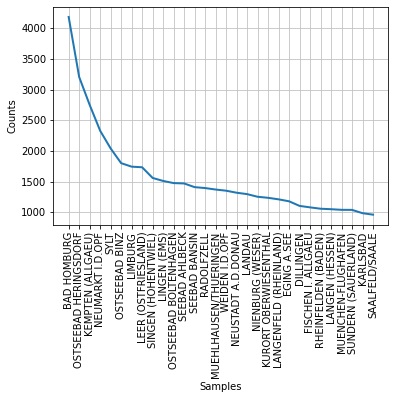

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [51]:
flat_list_missed_vg_ort = [item for item in dafsdf['VG_ORT']]
fdist_unique_missed_vg_ort = FreqDist(flat_list_missed_vg_ort)
fdist_unique_missed_vg_ort.plot(30,cumulative=False)

In [8]:
flat_list_vg_ort = [item for item in allclaims_df['VG_ORT']]
fdist_vg_ort = FreqDist(flat_list_vg_ort)
most_common_terms_vg_ort = [i[0] for i in fdist_vg_ort.most_common(30)] 
df_featurize_vg_ort = pd.DataFrame(allclaims_df['VG_ORT'])

for term in most_common_terms_vg_ort :
    df_featurize_vg_ort['location_'+term]=df_featurize_vg_ort['VG_ORT'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_vg_ort.head(10))

,VG_ORT,location_BERLIN,location_MUENCHEN,location_HAMBURG,location_KOELN,location_STUTTGART,location_LEIPZIG,location_FRANKFURT AM MAIN,location_DRESDEN,location_HANNOVER,...,location_ERFURT,location_KIEL,location_REGENSBURG,location_FREIBURG IM BREISGAU,location_CHEMNITZ,location_MAINZ,location_WUERZBURG,location_MAGDEBURG,location_POTSDAM,location_BIELEFELD
ID,,,,,,,,,,,,,,,,,,,,,
9938765,LISBERG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938766,LISBERG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938851,MUENCHEN,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938852,MUENCHEN,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938853,GRAFENRHEINFELD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938854,FRIESENRIED,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938855,HEIMENKIRCH,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938856,OBERHAID,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938857,MUENCHEN,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


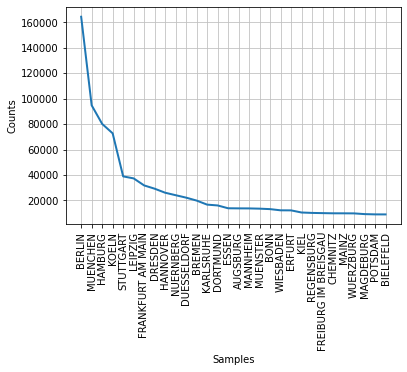

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [9]:
fdist_vg_ort.plot(30,cumulative=False)

TARIF_BEZ


In [10]:
flat_list_tarif_desc = [item for item in allclaims_df['TARIF_BEZ']]
fdist_tarif_desc = FreqDist(flat_list_tarif_desc)
most_common_terms_tarif = [i[0] for i in fdist_tarif_desc.most_common(30)] 
df_featurize_tarif = pd.DataFrame(allclaims_df['TARIF_BEZ'])

for term in most_common_terms_tarif :
    df_featurize_tarif['tarif_'+term]=df_featurize_tarif['TARIF_BEZ'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_tarif.head(10))

,TARIF_BEZ,tarif_U-V II. 1 (+II 2),tarif_U-K (MUSIKER),tarif_U-K (MUSIKER) MINDESTVERGUETUNG,tarif_U-ST I. (MUSIKER),tarif_E-P,tarif_U-K I (+ II 2B) - MIT SONSTIGEM GELDWERTEN VORTEIL,tarif_U-V III. 1,tarif_U-ST I (MUSIKER) NL,tarif_U-V III. 2,...,tarif_U-K II. (MUSIKER) BIS 10 MIN,tarif_VK I 3 ZIRKUSUNTERNEHMEN (MUSIKER),tarif_P-K I. (E-MUSIK),tarif_U-ST (MUSIKER),tarif_U-K II. (MUSIKER) BIS 5 MIN,tarif_U-K II. (MUSIKER) BIS 35 MIN,tarif_U-K II. (MUSIKER) BIS 40 MIN,tarif_U-V-KS (MUSIKER),tarif_U-K II (MUSIKER) MINDESTVERGUETUNG,tarif_U-K II. (MUSIKER) BIS 45 MIN
ID,,,,,,,,,,,,,,,,,,,,,
9938765,U-K (MUSIKER),0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938766,U-K (MUSIKER),0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938851,U-K (MUSIKER) MINDESTVERGUETUNG,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938852,U-K (MUSIKER) MINDESTVERGUETUNG,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938853,U-K (MUSIKER),0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938854,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938855,U-K (MUSIKER),0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938856,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938857,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


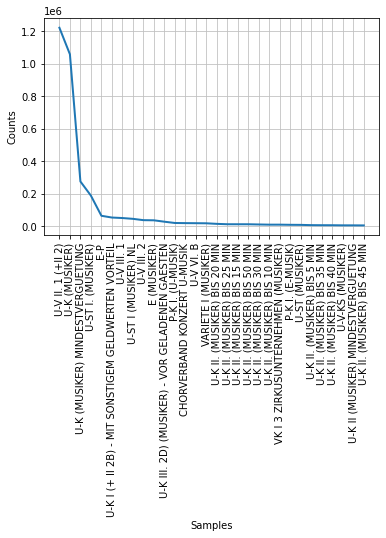

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [11]:
fdist_tarif_desc.plot(30,cumulative=False)

In [ ]:
# google maps API
# how big the city is?
# how close the location to the city centre?

VG_RAUM

In [12]:
nlp = spacy.load('de_core_news_sm')
nlp_en = spacy.load('en_core_web_sm')

In [ ]:
# nltk.download('punkt')

In [13]:
# Find all the categories of VG_RAUM
allclaims_df['VG_RAUM_clean']=allclaims_df['VG_RAUM'].astype(str).fillna('').map(lambda x: re.sub(r'\W+', ' ', x))
allclaims_df['VG_RAUM_tokenized']=allclaims_df['VG_RAUM_clean'].apply(word_tokenize, language='german')

flat_list = [item for sublist in allclaims_df['VG_RAUM_tokenized'].tolist() for item in sublist]

In [14]:
# german_stop_words = stopwords.words('german')
german_stop_words = nlp.Defaults.stop_words
english_stop_words = nlp_en.Defaults.stop_words
# english_stop_words = stopwords.words('english')

In [15]:
def remove_special_chars_from(stopwords):
    cleaned_stop_words = []
    for each in stopwords:
        each = each.replace('ß','SS')
        each = each.upper()
        each = each.replace('Ä', 'AE')
        each = each.replace('Ö', 'OE')
        each = each.replace('Ü', 'UE')
        
        cleaned_stop_words.append(each)
    return cleaned_stop_words

In [16]:
cleaned_de_stopwords = remove_special_chars_from(german_stop_words)
text_wo_stop_words = [word for word in flat_list if word.lower() not in cleaned_de_stopwords]

additional_stopwords = [
    'ST', 'FREIEN', 'BAD', 'HAUS', 'EV', 'BERLIN', 'KATH', 'S', 'HOF', 'ALTE', 'MITTE', 'LUTH', 'MUENCHEN',
    'IRISH', 'MUSIK', 'KULTUR', 'FUER', 'EVANG', 'MARITIM', 'KOELN', 'U', 'TURN', 'E', 'STUTTGART', 'ALTES',
    'A', 'GASTES', 'THE', 'EUROPA', 'HANNOVER', 'STADT', 'BADEN', 'NUERNBERG', 'HAMBURG', 'NEUE',
    'EVANGELISCHE', 'LEIPZIG', 'B', 'DRESDEN', 'BREMEN', 'PETER', '1','ALTER', 'AM', 'DIE', 'DER',
    'DAS', 'DES', 'DEN', 'DEM', 'EIN', 'EINER', 'EINEM', 'EINES', 'EINE',
    'MEIN', 'MEINER', 'MEINES', 'MEINEM', 'MEINE', 'UND'
]

text_wo_stop_words_2 = [word for word in text_wo_stop_words if word not in additional_stopwords]

text_wo_stop_words_3 = ['KIRCHE' if 'KIRCHE' in word else word for word in text_wo_stop_words_2 ]

# display(text_wo_stop_words_3)

In [ ]:
fdist_raum = FreqDist(text_wo_stop_words_3)
print(fdist_raum)

fdist_raum.plot(30,cumulative=False)

plt.show()

In [ ]:
print('Unique band values: {}'.format(len(allclaims_df.BAND.unique())))
# Null band values = 943181
# Total Band values = 2029523
print('Total non null band count: {}'.format(2029523-943181))


In [17]:
all_stopwords = cleaned_de_stopwords + additional_stopwords + list(english_stop_words)
all_stopwords = list(map(lambda x: x.lower(), all_stopwords))

room_list_wo_stopwords = []
for each_room in allclaims_df['VG_RAUM_clean'].tolist():
    for each_stopword in all_stopwords:
        # Remove stopword from each row in VG_RAUM_clean 
        each_room.replace(each_stopword,'')
        
    if 'KIRCHE' in each_room:
        room_list_wo_stopwords.append('KIRCHE')
    else:
        room_list_wo_stopwords.append(each_room)

In [ ]:
# joined_text_wo_stopwords = ','.join(room_list_wo_stopwords)

In [18]:
room_list_wo_stopwords = list(map(lambda x: x.lower(), room_list_wo_stopwords))

In [19]:
allclaims_df['VG_RAUM_WO_STOPWORDS'] = room_list_wo_stopwords

### Get keywords Using Rake

In [ ]:
from rake_nltk import Rake

In [ ]:
r = Rake()

r.extract_keywords_from_text(joined_text_wo_stopwords)
rankedList = r.get_ranked_phrases_with_scores()

In [ ]:
keywordList           = []

for keyword in rankedList:
  keyword_updated       = keyword[1].split()
  keyword_updated_string    = " ".join(keyword_updated[:2])
  keywordList.append(keyword_updated_string)
#   if(len(keywordList)>9):
#     break
# print(keywordList)

In [ ]:
most_common_list = Counter(keywordList).most_common(30)

keyword_list = []
counts = []

for each in most_common_list:
    keyword_list.append(each[0])
    counts.append(each[1])


plt.plot(keyword_list, counts)
plt.xticks(rotation=90)
plt.show()

In [ ]:
fdist_vg_raum_rake = FreqDist(most_common_list)
fdist_vg_raum_rake.plot(30,cumulative=False)

# plt.show()

In [ ]:
(73.15166945520723, 'view 200 dortmunder u 7 og leonie reygers terrasse 44137 dortmun'), 
(73.15166945520723, 'view 200 dortmunder u 7 og leonie reygers terrasse 44137 dortmun'), 
(73.15166945520723, 'view 200 dortmunder u 7 og leonie reygers terrasse 44137 dortmun'),
(63.331820639281666, 'real pc 2319 1003 ks 49 1003 9000 saarbruecken'), 
(63.331820639281666, 'real pc 2319 1003 ks 49 1003 9000 saarbruecken'), 
(58.33024052020611, 'praeparandie sinzig praxis fuer psychiatrie neurologie und imp gespr'), 
(58.32403096060591, 'real pc 2319 1955 ks 49 1955 9000'), 
(58.32403096060591, 'real pc 2319 1955 ks 49 1955 9000'), 
(58.32403096060591, 'real pc 2319 1732 ks 49 1732 9000'), 
(58.32403096060591, 'real pc 2319 1732 ks 49 1732 9000'), 
(58.32403096060591, 'real pc 2319 1716 ks 49 1716 9000'), 
(58.32403096060591, 'real pc 2319 1716 ks 49 1716 9000'), 
(57.83704866897864, 'leistungsempfaenger hoeffner moebelges gmbh co kg pankstr 32 13357 b'),
(56.887636709347206, 'moog 100 dortmunder u eg leonie reygers terrasse 44137 dortmund'), 
(56.527632852372335, 'hoeffner moebelges gmbh co kg rabenaustr 3 9 63584 gruendau'), 
(55.000939752317215, 'seelandhallen achtern diek gaestezentrum und spiel und spass scheun'), 
(54.97274199708599, 'bar ick koof mir dave lombardo wenn ick reich bin'), 
(53.74321256251726, 'leistungsempfaenger hoeffner moebelges gmbh co kg holsteiner ch 130'), 
(53.22730842308371, 'leistungsempfaenger hoeffner moebelges gmbh cokg inder schmalau40 9076'), 
(53.22730842308371, 'leistungsempfaenger hoeffner moebelges gmbh cokg inder schmalau40 9076'), 
(53.22730842308371, 'leistungsempfaenger hoeffner moebelges gmbh cokg inder schmalau40 9076'), 
(53.03487922918392, 'leistungsempfaenger hoeffner moebelges gmbh co kg hansestr 28 18182'), 
(53.01198737064888, 'europaeische stiftung der rahn dittrich group fuer bildung und kultur'), 
(53.01198737064888, 'europaeische stiftung der rahn dittrich group fuer bildung und kultur'), 
(50.92969436071396, 'zk u zentrum fuer kunst und urbanistik im ehem gueterbahnhof moabit'), 
(50.92969436071396, 'zk u zentrum fuer kunst und urbanistik im ehem gueterbahnhof moabit'), 
(50.92969436071396, 'zk u zentrum fuer kunst und urbanistik im ehem gueterbahnhof moabit'), 
(50.51442642054456, 'private kliniken dr dr med nebel vogtland klinik bad elster'), 
(50.51442642054456, 'private kliniken dr dr med nebel vogtland klinik bad elster'), 
(50.51442642054456, 'private kliniken dr dr med nebel vogtland klinik bad elster'),  
(50.51442642054456, 'private kliniken dr dr med nebel vogtland klinik bad elster')


In [ ]:
# Stemming - removes suffixes and prefixes from word roots, 
# Lemmatization - maps the remaining root forms (which may not always be proper words) back to an actual word that occurs in natural language.

Get keywords using spacy

In [22]:
def get_keywords(text):
    result = []
    pos_tag = ['PROPN', 'NOUN', 'VERB']
    # pos_tag = ['NOUN'] 
    # docd = nlp(text) 
    for token in text:
        if(token.text in all_stopwords or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            result.append(token.text)
        
        # print(token.text, token.pos_,token.dep_)    
    return result

In [ ]:
# len(joined_text_wo_stopwords)

In [23]:
raum_cleaned_df = (row.VG_RAUM_WO_STOPWORDS for row in allclaims_df.itertuples())

vg_raum_keywords = []
for each_object in nlp.pipe(raum_cleaned_df):
  vg_raum_keywords.append(get_keywords(each_object))
  # print(len(vg_raum_keywords))


In [24]:
allclaims_df['VG_RAUM_KEYWORDS'] = vg_raum_keywords

In [ ]:
print(allclaims_df.VG_RAUM_KEYWORDS)

In [25]:
flat_list_vg_raum_keywords = [item for sublist in allclaims_df['VG_RAUM_KEYWORDS'] for item in sublist]
fdist_vg_raum_keywords = FreqDist(flat_list_vg_raum_keywords)
most_common_terms_vg_raum = [i[0] for i in fdist_vg_raum_keywords.most_common(30)] 
df_featurize_vg_raum_keywords = pd.DataFrame(allclaims_df['VG_RAUM_KEYWORDS'])

for term in most_common_terms_vg_raum :
    df_featurize_vg_raum_keywords['place_'+term]=df_featurize_vg_raum_keywords['VG_RAUM_KEYWORDS'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_vg_raum_keywords.head(10))

,VG_RAUM_KEYWORDS,place_kirche,place_hotel,place_theater,place_cafe,place_club,place_halle,place_schloss,place_gaststaette,place_festhalle,...,place_rathaus,place_schule,place_museum,place_arena,place_schlachthof,place_kurhaus,place_zelt,place_grundschule,place_forum,place_wandelhalle
ID,,,,,,,,,,,,,,,,,,,,,
9938765,"[turnhalle, sv, rw, lisberg]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938766,"[turnhalle, sv, rw, lisberg]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938851,"[werner, siemens, schulzentrum]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938852,[kirche],1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938853,[grafenrheinfeld],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938854,"[vereinsheim, tsv, friesenried]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938855,"[paul, baeck]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938856,"[sportheim, sporthalle]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938857,[],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


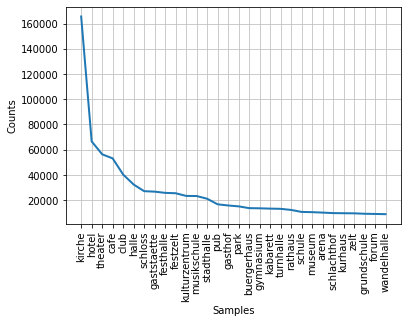

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [26]:
fdist_vg_raum_keywords.plot(30,cumulative=False)

VERANST_SEGMENT

In [ ]:
allclaims_df.VERANST_SEGMENT = allclaims_df['VERANST_SEGMENT'].astype(int)

VG_DATUM

In [ ]:
allclaims_df['VG_DATUM_YEAR'] = allclaims_df['VG_DATUM_VON'].dt.year
allclaims_df['VG_DATUM_MONTH'] = allclaims_df['VG_DATUM_VON'].dt.month
allclaims_df['VG_DATUM_DAY_OF_WEEK']=allclaims_df['VG_DATUM_VON'].dt.dayofweek

seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
claim_season_list = [seasons[item-1] for item in allclaims_df['VG_DATUM_MONTH']]

allclaims_df['VG_DATUM_SEASON'] = claim_season_list

In [ ]:
tarif_U-V II. 1 (+II 2)
tarif_U-K (MUSIKER)
tarif_U-K (MUSIKER) MINDESTVERGUETUNG
tarif_U-ST I. (MUSIKER)
tarif_E-P
tarif_U-K I (+ II 2B) - MIT SONSTIGEM GELDWERTEN VORTEIL
tarif_U-V III. 1
tarif_U-ST I (MUSIKER) NL
tarif_U-V III. 2
tarif_E (MUSIKER)
tarif_U-K III. 2D) (MUSIKER) - VOR GELADENEN GAESTEN
tarif_P-K I. (U-MUSIK)
tarif_CHORVERBAND KONZERT U-MUSIK
tarif_U-V VI. B
tarif_VARIETE I (MUSIKER)
tarif_U-K II. (MUSIKER) BIS 20 MIN
tarif_U-K II. (MUSIKER) BIS 25 MIN
tarif_U-K II. (MUSIKER) BIS 15 MIN
tarif_U-K II. (MUSIKER) BIS 50 MIN
tarif_U-K II. (MUSIKER) BIS 30 MIN
tarif_U-K II. (MUSIKER) BIS 10 MIN
tarif_VK I 3 ZIRKUSUNTERNEHMEN (MUSIKER)
tarif_P-K I. (E-MUSIK)
tarif_U-ST (MUSIKER)
tarif_U-K II. (MUSIKER) BIS 5 MIN
tarif_U-K II. (MUSIKER) BIS 35 MIN
tarif_U-K II. (MUSIKER) BIS 40 MIN
tarif_U-V-KS (MUSIKER)
tarif_U-K II (MUSIKER) MINDESTVERGUETUNG
tarif_U-K II. (MUSIKER) BIS 45 MIN


place_KIRCHE
place_HOTEL
place_STADTHALLE
place_CLUB
place_BUERGERHAUS
place_THEATER
place_HALLE
place_FESTHALLE
place_KURHAUS
place_SCHLOSS
place_CAFE
place_KULTURZENTRUM
place_FESTZELT
place_MUSIKSCHULE
place_MEHRZWECKHALLE
place_PUB
place_BAR
place_TURNHALLE
place_GASTHAUS
place_GYMNASIUM
place_RATHAUS
place_PARK
place_GASTHOF
place_KABARETT
place_SCHUETZENHALLE
place_GEMEINDEHALLE
place_GASTSTAETTE
place_SCHULE
place_MUSEUM
place_VEREINSHEIM

location_BERLIN
location_MUENCHEN
location_HAMBURG
location_KOELN
location_STUTTGART
location_LEIPZIG
location_FRANKFURT AM MAIN
location_DRESDEN
location_HANNOVER
location_NUERNBERG
location_DUESSELDORF
location_BREMEN
location_KARLSRUHE
location_DORTMUND
location_ESSEN
location_AUGSBURG
location_MANNHEIM
location_MUENSTER
location_BONN
location_WIESBADEN
location_ERFURT
location_KIEL
location_REGENSBURG
location_FREIBURG IM BREISGAU
location_CHEMNITZ
location_MAINZ
location_WUERZBURG
location_MAGDEBURG
location_POTSDAM
location_BIELEFELD

Merge all the features

In [ ]:
allclaims_feature_df = allclaims_df.merge(df_featurize_vg_raum_keywords, how='left', on='ID')
allclaims_feature_df = allclaims_feature_df.merge(df_featurize_tarif, how='left', on='ID')
allclaims_feature_df = allclaims_feature_df.merge(df_featurize_vg_ort, how='left', on='ID')

In [ ]:
allclaims_feature_df=allclaims_feature_df.rename(str.lower, axis='columns')

In [ ]:
# Feautes used - 'VG_RAUM_KEYWORDS', 'VG_DATUM_VON', 'VG_ORT', 'TARIF_BEZ'
features = ['tarif_u-v ii. 1 (+ii 2)', 'tarif_u-k (musiker)', 
'tarif_u-k (musiker) mindestverguetung','tarif_u-st i. (musiker)', 
'tarif_e-p', 'tarif_u-k i (+ ii 2b) - mit sonstigem geldwerten vorteil', 
'tarif_u-v iii. 1', 'tarif_u-st i (musiker) nl', 'tarif_u-v iii. 2', 
'tarif_e (musiker)', 'tarif_u-k iii. 2d) (musiker) - vor geladenen gaesten', 
'tarif_p-k i. (u-musik)', 'tarif_chorverband konzert u-musik', 
'tarif_u-v vi. b','tarif_variete i (musiker)',
'tarif_u-k ii. (musiker) bis 20 min','tarif_u-k ii. (musiker) bis 25 min',
'tarif_u-k ii. (musiker) bis 15 min','tarif_u-k ii. (musiker) bis 50 min',
'tarif_u-k ii. (musiker) bis 30 min','tarif_u-k ii. (musiker) bis 10 min',
'tarif_vk i 3 zirkusunternehmen (musiker)','tarif_p-k i. (e-musik)',
'tarif_u-st (musiker)','tarif_u-k ii. (musiker) bis 5 min',
'tarif_u-k ii. (musiker) bis 35 min','tarif_u-k ii. (musiker) bis 40 min',
'tarif_u-v-ks (musiker)','tarif_u-k ii (musiker) mindestverguetung',
'tarif_u-k ii. (musiker) bis 45 min',

'place_kirche','place_hotel','place_stadthalle','place_club',
'place_buergerhaus','place_theater','place_halle','place_festhalle',
'place_kurhaus','place_schloss','place_cafe','place_kulturzentrum',
'place_festzelt','place_musikschule','place_mehrzweckhalle','place_pub',
'place_bar','place_turnhalle','place_gasthaus','place_gymnasium',
'place_rathaus','place_park','place_gasthof','place_kabarett',
'place_schuetzenhalle','place_gemeindehalle','place_gaststaette',
'place_schule','place_museum','place_vereinsheim',

'location_berlin','location_muenchen','location_hamburg','location_koeln',
'location_stuttgart','location_leipzig','location_frankfurt am main',
'location_dresden','location_hannover','location_nuernberg','location_duesseldorf',
'location_bremen','location_karlsruhe','location_dortmund','location_essen',
'location_augsburg','location_mannheim','location_muenster','location_bonn',
'location_wiesbaden','location_erfurt','location_kiel','location_regensburg',
'location_freiburg im breisgau','location_chemnitz','location_mainz',
'location_wuerzburg','location_magdeburg','location_potsdam',
'location_bielefeld',

'vg_datum_year','vg_datum_month','vg_datum_day_of_week','vg_datum_season'
]

Basic SVM Classifier model to classify event segments

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
X = allclaims_feature_df[features]
y = allclaims_feature_df['veranst_segment']

In [ ]:
print(allclaims_df['VG_RAUM_KEYWORDS'].dtypes)
print(allclaims_df['VG_DATUM_VON'].dtypes)
print(allclaims_df['VG_ORT'].dtypes)
print(allclaims_df['TARIF_BEZ'].dtypes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

In [ ]:
# save the model to disk
filename = 'svc_classifier_model.sav'
pickle.dump(svclassifier, open(filename, 'wb'))

In [ ]:
y_pred = svclassifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
# Group the places by the state
# Find the missing places using the PLZ or using the VG_Raum

In [ ]:
# There are only 2 values in the INKASSO_NETTO and INKASSO_BRUTTO
# There are no null values in VG_INKASSO
# Lowest value of VG_INKASSO is 0.04 and highest value is 409.7
# How could segment 2 (0 - 50 euros) and segment 3 (50-100 euros) would have high VG_INKASSO values?


In [ ]:
morethan100 = allclaims_df[allclaims_df['VG_INKASSO']>100]
len(morethan100)

Multivariate Analysis

In [ ]:
# Null values
# VG_ORT - 146
# VERANST_ORT  368
# VG_RAUM/LOCATION - 95
# VERANST_NAME/PROMOTER  103
# TARIF_BEZ  0
# BAND  943181
# KAPELLE_NAME 960942
# sns.barplot(x=allclaims_df['VG_ORT'], y=df['VERANST_SEGMENT'])
# plt.show()

#box plot Place/Customer Segment
data = pd.concat([allclaims_df['VG_ORT'], df['VERANST_SEGMENT']], axis=1)
f, ax = plt.subplots(figsize=(80, 6))
fig = sns.boxplot(x="VG_ORT", y="VERANST_SEGMENT", data=data)
plt.xticks(rotation=90)

In [ ]:
# sns.barplot(x=allclaims_df['TARIF_BEZ'], y=df['VERANST_SEGMENT'])
# plt.show()
#box plot Tarif/Customer Segment
data = pd.concat([allclaims_df['TARIF_BEZ'], df['VERANST_SEGMENT']], axis=1)
f, ax = plt.subplots(figsize=(80, 8))
fig = sns.boxplot(x="TARIF_BEZ", y="VERANST_SEGMENT", data=data)
# fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90)
# 54 Tarifs used frequently

In [ ]:
# Find the relationship between tarif, customer segment and the band that performed
sns.boxplot(x="TARIF_BEZ", y="VERANST_SEGMENT", hue="BAND", data=allclaims_df);

In [ ]:
# Find the relationship between tarif, customer segment and the location the event was performed
sns.boxplot(x="TARIF_BEZ", y="VERANST_SEGMENT", hue="LOCATION", data=allclaims_df);

Relationship with features

Correlation

In [ ]:
# Find correlation of customer segments and other variables
allclaims_df.corr()['VERANST_SEGMENT'].sort_values(ascending=False)

In [ ]:
# Find correlation of VG_INKASSO and other variables
allclaims_df.corr()['VG_INKASSO'].sort_values(ascending=False)

In [ ]:
allclaims_df.corr()

In [ ]:
sns.heatmap(allclaims_df.corr(), cmap='coolwarm')

Outliers